# Recommendations with IBM

In this notebook, it shows recommendation on real data from the IBM Watson Studio platform to recommand articles for its user by mainly Rank Based Recommendations and User-User Based Collaborative Filtering usage.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br> 
V. [Extras & Concluding](#conclusions)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


`1.` What is the distribution of how many articles a user interacts with in the dataset?

In [3]:
#quick look for null values
print(df.isnull().sum(),df_content.isnull().sum()) 

article_id     0
title          0
email         17
dtype: int64 doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64


In [4]:
#The number of unique articles that have at least one interaction
df.article_id.nunique()#we have almost 714 unique articles
#df.article_id.nunique(dropna=True)

714

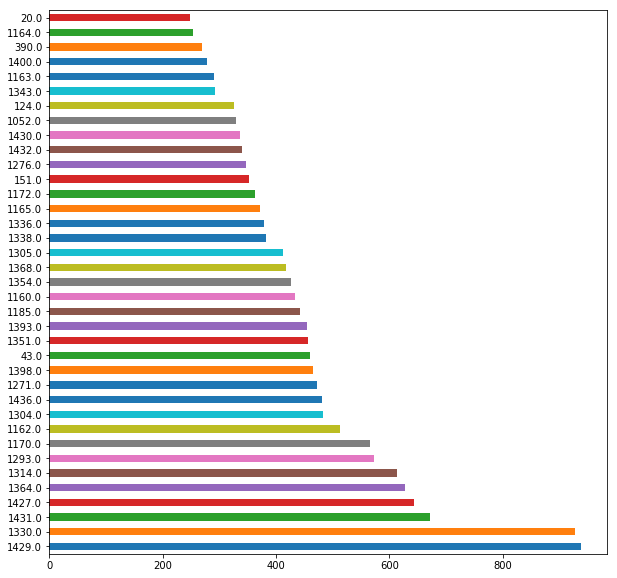

In [5]:
# let's see the most interacted articles
df.article_id.value_counts()[:20].plot(kind='barh',figsize=(10,10))

In [6]:
#50% of individuals interact with ____ number of articles or fewer.
#df.email.nunique()
#indv_count = df.groupby('email'[:2500]).count()['article_id'].sum()
df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

In [7]:
# The maximum number of user-article interactions by any 1 user is ______.
max_views = df.groupby('email').count()['article_id'].max()
max_views

364

In [8]:

#50% of individuals interact with ____ number of articles or fewer.
median_val = 3 
# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = 364

`2.` Data exploration the **df_content** dataframe.  

In [9]:
# Duplicate articles
df_content.duplicated(subset='article_id').sum()

5

In [10]:
#Show duplicate articles
df_content[df_content.duplicated(subset=['article_id'])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [11]:
# Remove rows that have the same article_id
df_content.drop_duplicates(subset='article_id',keep='first',inplace=True)
#df_content = df_content[~df_content.duplicated(subset=['article_id'])]

In [12]:
# Checking after drop
df_content.duplicated(subset=['article_id']).sum()

0

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:
# The number of unique users
#df[df['email'] == 'ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7'].nunique()
df.email.nunique(dropna=True)

5148

In [14]:
# The number of unique articles on the IBM platform
df_content.article_id.nunique()

1051

In [15]:
exp= df.groupby('email')['article_id'].value_counts()
exp

email                                     article_id
0000b6387a0366322d7fbfc6434af145adf7fed1  43.0          2
                                          124.0         1
                                          173.0         1
                                          288.0         1
                                          349.0         1
                                          618.0         1
                                          732.0         1
                                          1162.0        1
                                          1232.0        1
                                          1314.0        1
                                          1337.0        1
                                          1354.0        1
001055fc0bb67f71e8fa17002342b256a30254cd  124.0         1
                                          254.0         1
                                          390.0         1
                                          1386.0        1
00148e4911c7e04eeff

In [16]:
#The number of user-article interactions
df.shape[0]

45993

In [17]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 #The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [18]:
# The most viewed article in the dataset was viewed how many times?
df[df['article_id'] == 1429.0]['article_id'].count()

937

In [19]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [20]:
#change email column values into unique user ids
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [22]:
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` the function to return the **n** top articles ordered with most interactions as the top.

In [23]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles=[]
    articles_id_list= list(df.article_id.value_counts().sort_values(ascending=False).index[:n])
    for i in articles_id_list:
        article = df[df['article_id'] == i]['title'].iloc[0]
        top_articles.append(article)
    
    return top_articles # Returns the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles_ids = list(df.article_id.value_counts().sort_values(ascending=False).index[:n])
 
    return top_articles_ids # Returns the top article ids

In [24]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [26]:
print(df.shape)

(45993, 3)


In [27]:
#df.article_id.unique()
#df.groupby(['user_id', 'article_id'])['title'].count().unstack()

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` The function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** will only appear in each **row** once.


* Each **article** will only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 


In [28]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    #Create new df_new columns
    
    #column = df.article_id.unique()
    #df_new.columns = column
    
    #ustack is an easier way
    user_item= df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item = user_item.notnull().astype(int)
    
    
    return user_item # returns the user_item matrix 

user_item = create_user_item_matrix(df)

`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 


In [30]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
   
    similar_users = user_item.dot(user_item.loc[user_id])
    
    # sort by similarity
    similar_users= similar_users.sort_values(ascending=False)

    # create list of just the ids
    ids= similar_users.index
   
    # remove the own user's id
    most_similar_users= ids.drop(user_id) #can't use remove here, 
    #AttributeError: 'builtin_function_or_method' object has no attribut
    
    return most_similar_users # returns a list of the users in order from most to least similar
        

In [31]:
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: Int64Index([3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041], dtype='int64', name='user_id')
The 5 most similar users to user 3933 are: Int64Index([1, 23, 3782, 4459, 203], dtype='int64', name='user_id')
The 3 most similar users to user 46 are: Int64Index([4201, 23, 3782], dtype='int64', name='user_id')


`3.` Get the article names for each user

In [32]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names=[]
    for i in article_ids:
        ArticleName = df[df['article_id'] == float(i)]['title'].values[0] # I have to float i to be recogized
        article_names.append(ArticleName)
    
    return article_names # Returns the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids=[]
    user_list = dict(user_item.loc[user_id])
    user_list
    for key, value in user_list.items():
        if value == 1:
            article_ids.append(key)
        else:
            continue
    
    
    #get the articles titles
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # returns the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    read_article_ids, read_article_names = get_user_articles(user_id)
    similars = find_similar_users(user_id)
    
    for user in similars:
        article_ids, article_names = get_user_articles(user)
        not_read = list(set(article_ids) - (set(read_article_ids)& set(article_ids)))
        
        recs.extend(not_read)
        if len(recs) > m:
            break
    
    return recs[:m] # returns your recommendations for this user_id    

In [ ]:
'''
#user_item.iloc[2]#get 2nd in index
read_list=[]
x = dict(user_item.loc[1])
x
for key, value in x.items():
    if value == 1:
        read_list.append(key)
    else:
        continue
print(read_list)
'''

In [ ]:
#x= dict(user_item.loc[1])
#x.items()

In [33]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Returns 10 recommendations for user 1

['data tidying in data science experience',
 'this week in data science (april 18, 2017)',
 'shaping data with ibm data refinery',
 'timeseries data analysis of iot events by using jupyter notebook',
 'data science platforms are on the rise and ibm is leading the way',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'a tensorflow regression model to predict house values',
 'deep forest: towards an alternative to deep neural networks']

In [34]:
get_user_articles(20)[0] #That's right

[232.0, 844.0, 1320.0]

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function written earlier.

In [36]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    #Get each user interaction with articles count from df in new df
    num_interactions = pd.DataFrame(df.groupby('user_id')['article_id'].count())
    #Create neighbor_id column
    #neighbor_id = list([user for user in range (1,user_item.shape[0]) if user != user_id])
    
    #Similarity
    similarity = user_item.dot(user_item.loc[user_id]).sort_values(ascending=False)
    similarity.drop(user_id, inplace=True) #drop own user_id from similarity
    similarity = similarity.to_frame('similarity').reset_index()
    
    neighbors_df = similarity.merge(num_interactions, left_on='user_id',
                                    right_index=True).rename(columns={'user_id':'neighbor_id'})
    '''
    similarity = []
    user_interact = []
    for user in neighbor_id:
        user_interact.append(user_interactions.loc[user])
        similarity.append(user_item.dot(user_item.loc[user_id], user_item.loc[user]))
    
    #Dataframe creation
    
    neighbors_df = pd.DataFrame({'neighbor_id': neighbor_id ,
                                 'similarity': similarity , 
                                 'num_interactions':user_interact })
    
    '''
    #Sort users by similarity
    neighbors_df.sort_values(by=['similarity'], ascending=False, inplace=True)
    
    
    return neighbors_df # Returns the dataframe specified in the doc_string




 '''
#def user_user_recs_part2(user_id, m=10):
   
   
   
    This code will be commented as it took ages to run :(
    recs, rec_names = [],[]
    
    read_article_ids, read_article_names = get_user_articles(user_id)
    similars_df = get_top_sorted_users(user_id)
    
    # Get articles viewed by top silimalrs and recs list
    for neighbour in similars_df['neighbor_id']:
        neighbours_seen_articles = list(user_item.columns[np.where(user_item.loc[neighbour] == 1)])
        for article_id in neighbours_seen_articles:
            if article_id not in read_article_ids:
                recs.append(recs)
        if len(recs)>=m:
            break
    
    #recometation names
    rec_names = list(set(df[df['article_id'].isin(recs)]['title']))
    '''

In [37]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   '''
    # Get neighbors
    neighbors_df = get_top_sorted_users(user_id)
    
    # Top neighbors
    top_neighbors = list(neighbors_df[:m]['neighbor_id'])

    # Articles viewed by top neighbors
    recs = []
    for user in top_neighbors:
        article_ids = user_item.loc[user]
        recs.extend([str(article) for article in article_ids[article_ids == 1].index])

    # Unique values
    recs = list(set(recs[:m]))

    # Find unique article names
    rec_names = list(set(df[df['article_id'].isin(recs)]['title']))
    
    
    return recs[:m], rec_names[:m] 

In [38]:
user_item.columns[np.where(user_item.loc[5]==1)]

Float64Index([1166.0, 1276.0, 1351.0], dtype='float64', name='article_id')

In [39]:
# test function
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['43.0', '213.0', '313.0', '337.0', '111.0', '112.0', '225.0', '232.0', '109.0', '164.0']

The top 10 recommendations for user 20 are the following article names:
['modeling energy usage in new york city', 'what is machine learning?', 'deep learning with tensorflow course by big data university', 'tensorflow quick tips', 'learn tensorflow and deep learning together and now!', 'self-service data preparation with ibm data refinery', 'a visual explanation of the back propagation algorithm for neural networks', 'tidy up your jupyter notebooks with scripts', 'building custom machine learning algorithms with apache systemml', 'generalization in deep learning']


`5.` If we were given a new user, which of the above functions would you be able to use to make recommendations? 

**Since I have no history data for that new user, then I will recommand him/her, highly seen or popular articles using get_top_articles(n) while n is the number of articles lets say 5 articles.**

**Maybe using knowledge based or content based recommendation engine.**

In [49]:
new_user = '0.0'

# What would the recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# a list of the top 10 article ids I would give to 
new_user_recs = get_top_article_ids(10)

In [50]:
set(new_user_recs)

{1162.0,
 1170.0,
 1293.0,
 1304.0,
 1314.0,
 1330.0,
 1364.0,
 1427.0,
 1429.0,
 1431.0}

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, I build matrix factorization to make article recommendations to the users.

In [54]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [55]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
# Perform SVD on the User-Item Matrix 
u, s, vt = np.linalg.svd(user_item_matrix)

In [57]:
#Checking matrices dimensions
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Since user_item_matrix has only values of 0s for the unread articles and 1s for the read ones, we don't have a NaN values which makes SVD vaild to be used here. In case of NaNs existance we'll use FunkSVD as a solution.**

`3.`how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

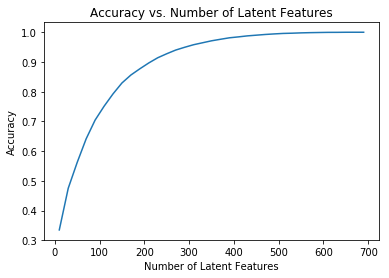

In [58]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  


In [59]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    #Test user ids
    test_idx = user_item_test.index
    test_idx = list(set(test_idx))
    
    # Test article ids
    test_arts = user_item_test.columns
    test_arts = list(set(test_arts))
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [60]:
#How many users can we make predictions for in the test set?
print(len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique())))
#How many users in the test set are we not able to make predictions for because of the cold start problem?
print(len(df_test['user_id'].unique()) - len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique())))
#How many articles can we make predictions for in the test set?
print(len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique())))
#How many articles in the test set are we not able to make predictions for because of the cold start problem?
print(len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique())))

20
662
574
0


`5.` Now using the **user_item_train** dataset from above to find U, S, and V transpose using SVD. finding the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data.


In [62]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [63]:
# Model Variables
train_idx = np.array(user_item_train.index)
train_arts = np.array(user_item_train.columns)

# Users and articles of test set in training set
test_idx_set = np.intersect1d(test_idx, train_idx)
test_arts_set = np.intersect1d(test_arts, train_arts)

# Users and articles positions of test subset in training matrix
train_indexes = np.where(np.in1d(train_idx, test_idx_set))[0]
train_articles = np.where(np.in1d(train_arts, test_arts_set))[0]

# Users positions of test subset in test matrix
test_indexes = np.where(np.in1d(test_idx, test_idx_set))[0]

In [64]:
#find subset of user_item matrix containing only user and articles that are shared by train and test set as full one gets 
#an error of operation issue due to size
u_item_test_set = user_item_test.iloc[test_indexes,:]
u_item_train_set = user_item_train.iloc[train_indexes, train_articles]

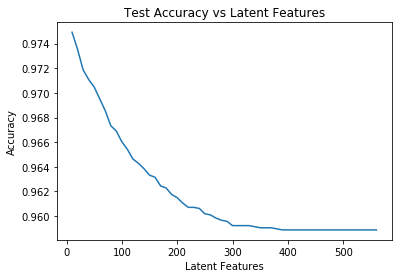

In [65]:
#Iterate through latent features to make prediction
latent_feats = np.arange(10,570,10)
sum_errors = []

for k in latent_feats:
    
    # Restructure train matrices using k features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # Restructure test matrices using k features
    s_test_k, u_test_k, vt_test_k = s_train_k, u_train_k[train_indexes,:], vt_train_k[:,train_articles]
    
    # Calculate dot product
    u_item_test_set_pred = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # Error (prediction - actual values)
    error = np.subtract(u_item_test_set, u_item_test_set_pred)
    
    # Total errors
    total_error = np.sum(np.sum(np.abs(error)))
    sum_errors.append(total_error)

# Plot test accuracy and latent features
n_interactions_set = u_item_test_set.shape[0] * u_item_test_set.shape[1]
plt.plot(latent_feats, 1 - np.array(sum_errors) / n_interactions_set);
plt.xlabel('Latent Features');
plt.ylabel('Accuracy');
plt.title('Test Accuracy vs Latent Features');

**The accuracy on predictions decreased whenever latent features increased regarding the testing dataset, on the contrary is the training dataset. This might be due to the lack of common users between traing and test sets.**


<a id='conclusions'></a>


## Conclusion

**A better approach might be to do an online test instead of an offline test to determine the effectiveness of a rank based recommendation system against the matrix recommendation system. Using A/B testing where we can split the users into 2 groups , with the first group continuing with the old recommenadation system and the second group using the new recommendation functions.**